In [129]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from optimization import run_optimization
from optimization_class import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 1e-1                   # grid size (L0)
shape = (100,100)           # shape of domain (in grids)
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [161]:
# define the two port parameters
L = 3
H = 3
w = .2
d = 1.5
eps_m = 12

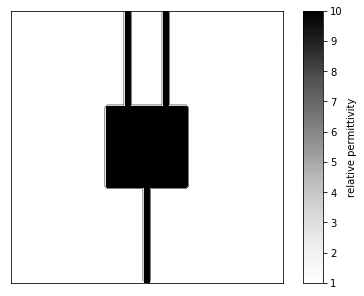

In [162]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, shape, eps_start=10)
simulation.reset_eps(eps_r)
simulation.plt_eps()

In [163]:
# set the modal source
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'y', [50, 20], int(d/dl))
simulation.setup_modes()

In [164]:
# set source and solve for electromagnetic fields
print(d/dl)
(Hx,Hy,Ez) = simulation.solve_fields()

15.0


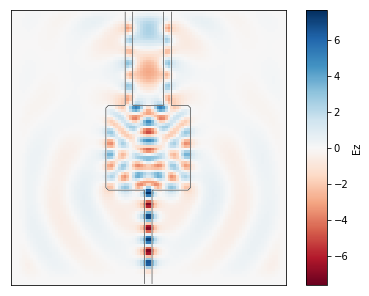

In [165]:
# plot linear field
simulation.plt_re(outline=True, cbar=True);

In [166]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[50, 80] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

## Purely Linear

## Both Linear and Nonlinear

In [167]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['total']     = lambda J_lin, J_nonlin: J_lin - J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin - dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [168]:
simulation.src = simulation.src*10

In [169]:

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=1000, J=J, dJdE=dJdE, eps_max=10, step_size=.001, solver='newton')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

 32% (326 of 1000) |######               | Elapsed Time: 0:34:19 ETA:   0:58:04

the simulation did not converge, reached 0.45492530923689845


 75% (759 of 1000) |###############      | Elapsed Time: 0:39:26 ETA:   0:25:51

the simulation did not converge, reached 0.21232063260778136


 83% (839 of 1000) |#################    | Elapsed Time: 0:40:30 ETA:   0:13:06

the simulation did not converge, reached 0.16594011277293955


 84% (844 of 1000) |#################    | Elapsed Time: 0:40:38 ETA:   0:12:41

the simulation did not converge, reached 0.31654540929916647


100% (1000 of 1000) |####################| Elapsed Time: 0:42:19 ETA:  00:00:00

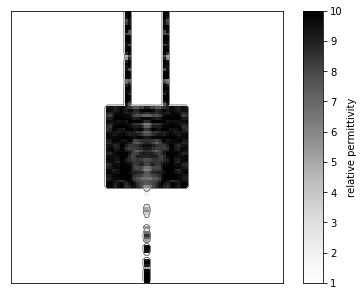

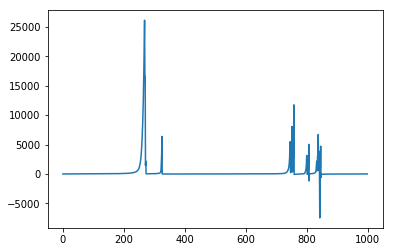

In [170]:
# note, it doesn't really change because the objective function is hard to satisfy 
# (respectively maximize and minimize linear and nonlinear intensity at point) 
# (the nonlinearity not high enough)
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

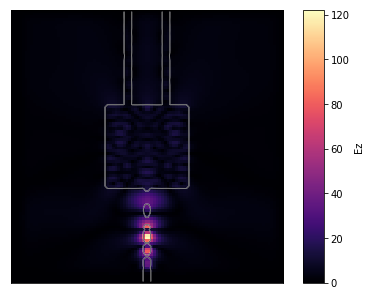

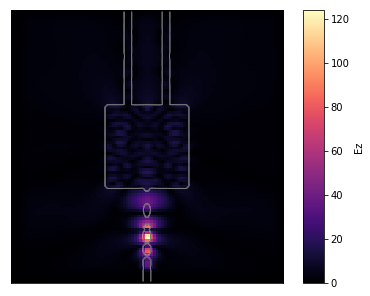

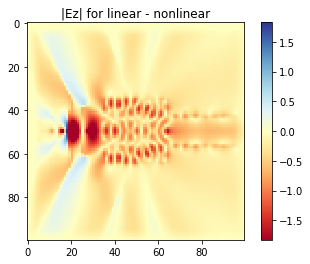

In [171]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=None,solver_nl='born')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez) - np.abs(Ez_nl)
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()


one can see from the last plot that the linear field is more intense at the measuring point, but only by a little bit.

## Nonlinear with larger input power

In [172]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [173]:
# Reset simulation and increase input power
simulation.src = 20*simulation.src
simulation.reset_eps(eps_r)

# note: already have a nonlinear optimization going so no need to recreate that

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_nonlinear.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

NameError: name 'opt_nonlinear' is not defined

In [ ]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=None,solver_nl='born')

simulation.plt_abs()

In [ ]:
simulation.src